## Vectice Configuration

In [2]:
#Install Vectice Python library 
# In this notebook we will do code versioning using github, we also support gitlab
# and bitbucket: !pip install -q "vectice[github, gitlab, bitbucket]"
!pip install --q vectice[github]==22.3.5.1

In [7]:
#Verify if Vectice python library was installed
!pip3 show vectice

Name: vectice
Version: 22.3.5.1
Summary: Vectice Python library
Home-page: https://www.vectice.com
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: python-dotenv, requests, urllib3
Required-by: 


In [8]:
import json
f = open('DSP_JDN.json',)
DSP_JDN_key = json.load(f)

In [9]:
#Import the required packages
from vectice import Experiment
from vectice.api.json import ModelType
from vectice.api.json import JobType
from vectice.api.json import JobArtifactType
from vectice.api.json import ModelVersionStatus
from vectice.api.json import VersionStrategy
import logging
import os
logging.basicConfig(level=logging.INFO)

# Specify the API endpoint for Vectice.
# You can specify your API endpoint here in the notebook, but we recommand you to add it to a .env file
os.environ['VECTICE_API_ENDPOINT']= "app.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API token.
# You can generate an API token from the Vectice UI, by going to the "API Tokens" section in the "My Profile" section
# which is located under your profile picture.
# You can specify your API Token here in the notebook, but we recommend you to add it to a .env file
os.environ['VECTICE_API_TOKEN'] = DSP_JDN_key['key']

# Add you project id. The project id can be found in the project settings page in the Vectice UI
project_id = 4734

## Setup environment for ML

In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:

import string
from math import sqrt

# Load scikit-learn packages
from sklearn.model_selection import train_test_split  # Model Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Model Evaluation
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regression

## Load Cleaned Training Data and Take a Peek

In [4]:
# Once your file is loaded you can view your dataset in a Pandas dataframe.
df = pd.read_csv('data/train_cleaned_kc_house_data.csv')
# We will use an 80/20 split to prepare the data
test_size = 0.2

# We will set the random seed so we always generate the same split.
random_state = 42

train, test = train_test_split(df, test_size = test_size, random_state = random_state)

# We commented out the code to persist the training and testing test in GCS, 
# because we already generated the data for you.
# The key provided for this tutorial give you read access only to GCS.
# We left the code below for convenience, in case you want to use your own credentials and GCS bucket.
# train.to_csv (r'gs://vectice_tutorial/training_data.csv', index = False, header = True)
# test.to_csv (r'gs://vectice_tutorial/testing_data.csv', index = False, header = True)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
X = df.drop("price", axis=1).values
y = df["price"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [5]:
X_train[:3]

array([[ 3.00000e+00,  2.50000e+00,  2.54000e+03,  4.76000e+03,
         2.00000e+00,  0.00000e+00,  0.00000e+00,  3.00000e+00,
         8.00000e+00,  2.54000e+03,  0.00000e+00,  2.01000e+03,
         0.00000e+00,  9.80380e+04,  4.73452e+01, -1.22022e+02,
         2.54000e+03,  4.57100e+03],
       [ 6.00000e+00,  2.25000e+00,  2.93000e+03,  1.59490e+04,
         1.00000e+00,  0.00000e+00,  0.00000e+00,  4.00000e+00,
         8.00000e+00,  1.73000e+03,  1.20000e+03,  1.96500e+03,
         0.00000e+00,  9.80340e+04,  4.77188e+01, -1.22185e+02,
         1.73000e+03,  8.55000e+03],
       [ 3.00000e+00,  1.50000e+00,  1.23000e+03,  7.20000e+03,
         1.00000e+00,  0.00000e+00,  0.00000e+00,  3.00000e+00,
         7.00000e+00,  1.23000e+03,  0.00000e+00,  1.95300e+03,
         0.00000e+00,  9.81250e+04,  4.77281e+01, -1.22311e+02,
         1.40000e+03,  6.24000e+03]])

## Let's benchmark first: Linear regression 

### 1. Create a Vectice job for the modeling stage

In [15]:
# We create our second experiment for modeling and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Modeling - train", project=project_id, job_type=JobType.TRAINING, auto_code=True)

INFO:Client:Successfully authenticated. You'll be working on Project: Predicting house prices in King County, Washington part of Workspace: .jnorman
INFO:Project:Job with id: 10767 successfully retrieved.


In [16]:
#create a code checkpoint for this version of the notebook
input_code = experiment.add_code_version_uri(git_uri="https://github.com/stbiadmin/vectice-examples",
                                             entrypoint="demo/demo_modeling.ipynb") 

INFO:Project:CodeVersion with id: 2785 successfully created in Code vectice-examples.


### 2. Load the dataset from the data prep stage, save some metadata about this step

In [19]:
train_ds_version = experiment.get_dataset_version(version=9961)
test_ds_version = experiment.get_dataset_version(version=9962)

INFO:Dataset:DatasetVersion with id: 9961 successfully retrieved from Dataset train_cleaned_kc_house_data.
INFO:Dataset:DatasetVersion with id: 9962 successfully retrieved from Dataset test_cleaned_kc_house_data.


In [39]:
#set some run properties to help us make sense of what is happening
technique = ["Approach", "Linreg"]
citation = ["wiki","https://en.wikipedia.org/wiki/Linear_regression"]

### 3. Wrap the model training step, and resulting metrics into an experiment run

In [40]:
# we declare the dataset versions and code to use as inputs of our run
experiment.start(inputs=[input_code, train_ds_version, test_ds_version],
                run_properties={technique[0]: technique[1], citation[0]:citation[1]})

# Linear regression model
lr_rg = LinearRegression()
lr_rg.fit(X_train, y_train)
lr_pred = lr_rg.predict(X_test)

# Evaluate Metrics
MAE = round(mean_absolute_error(lr_pred, y_test),3)
RMSE = round(sqrt(mean_squared_error(lr_pred, y_test)),3)

print("Root Mean Squared Error: ", RMSE)
print("Mean Absolute Error: ", MAE)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
metrics = {"RMSE": RMSE, "MAE": MAE}
model_version = experiment.add_model_version(model="Regressor", algorithm="Linear Regression", metrics=metrics)

# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()

INFO:RunApi:Properties with names: ['Approach', 'wiki'] successfully added to Run Run 2022-08-09T03:25:44.919893.
INFO:Job:Run with id: 18595 successfully created.


Root Mean Squared Error:  154238.92
Mean Absolute Error:  108422.203


INFO:Project:Model with id: 3804 successfully retrieved.
INFO:ModelVersionApi:Metrics with names: ['RMSE', 'MAE'] successfully added to ModelVersion Version 5.
INFO:Model:ModelVersion with id: 12595 successfully created in Model Regressor.


## Moving on..Let's try a Decision Tree

### 1. Just set the run properties and go!

In [45]:
#set some run properties to help us make sense of what is happening
technique = ["Approach", "DT"]
citation = ["wiki","https://en.wikipedia.org/wiki/Decision_tree_learning"]

### 2. Wrap the model training step, and resulting metrics into an experiment run

INFO:RunApi:Properties with names: ['Approach', 'wiki'] successfully added to Run Run 2022-08-09T03:37:54.059261.
INFO:Job:Run with id: 18597 successfully created.


Root Mean Squared Error: 137002.875
Mean Absolute Error: 88846.123


INFO:Project:Model with id: 3804 successfully retrieved.
INFO:ModelVersionApi:Hyperparameters with names: ['Tree Depth'] successfully added to ModelVersion Version 7.
INFO:ModelVersionApi:Metrics with names: ['RMSE', 'MAE'] successfully added to ModelVersion Version 7.
INFO:Model:ModelVersion with id: 12597 successfully created in Model Regressor.
INFO:AttachmentApi:Attachment with name: DecisionTree_8.png successfully attached to ModelVersion with id: 12597.


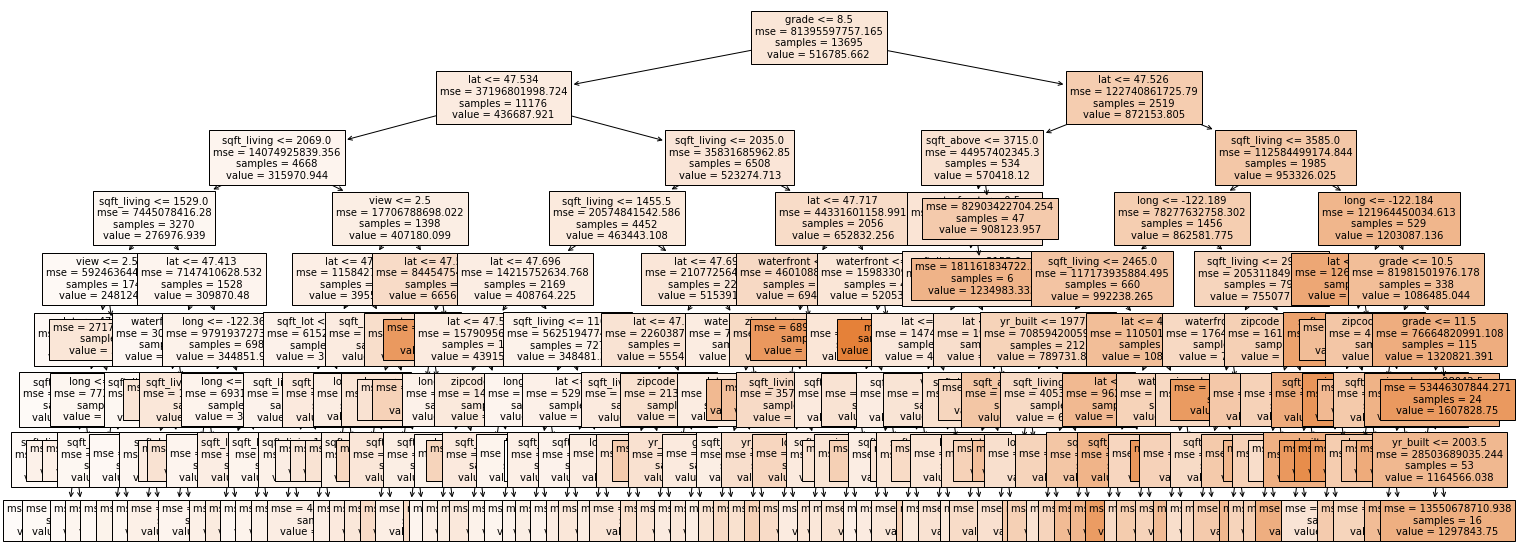

In [46]:
# We can do a few runs with different max depth for the tree.
# Just change the value below and re-run this cell.
tree_depth = 8

# we declare the dataset versions and code to use as inputs of our run
experiment.start(inputs=[input_code, train_ds_version, test_ds_version],
                run_properties={technique[0]: technique[1], citation[0]:citation[1]})


# Decision tree model
dtr = DecisionTreeRegressor(max_depth=tree_depth, min_samples_split=50)
dtr.fit(X_train,y_train)
dtr_pred = dtr.predict(X_test) 

data_feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                      'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
                      'long', 'sqft_living15', 'sqft_lot15']

# Visualize the Decision Tree Model
plt.figure(figsize=(25, 10))
plot_tree(dtr, feature_names=data_feature_names, filled=True, fontsize=10)
attachment_name = "DecisionTree_"+str(tree_depth)+".png"
plt.savefig(attachment_name)

MAE = round(mean_absolute_error(dtr_pred, y_test),3)
RMSE = round(sqrt(mean_squared_error(dtr_pred, y_test)),3)

print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Error:", MAE)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
metrics = {"RMSE": RMSE, "MAE": MAE}
model_version = experiment.add_model_version(model="Regressor", algorithm="Decision Tree", hyper_parameters={
                            "Tree Depth":tree_depth}, metrics=metrics, attachment=attachment_name)

# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()

## Since that was better, let's see if we can improve even more using an ensemble approach

### 1. Just set the run properties again and go!

In [ ]:
#set some run properties to help us make sense of what is happening
technique = ["Approach", "Ensemble: RF"]
citation = ["wiki","https://en.wikipedia.org/wiki/Random_forest"]

### 2. Wrap the model training step, and resulting metrics into an experiment run

In [25]:
# You can modify the parameters below and execute multiple runs to train 
## different versions of RF model.
nb_trees = 60
min_samples = 30

# we declare the dataset versions and code to use as inputs of our run
experiment.start(inputs=[input_code, train_ds_version, test_ds_version],
                run_properties={technique[0]: technique[1], citation[0]:citation[1]})

rf_regressor = RandomForestRegressor(n_estimators=nb_trees, min_samples_leaf=min_samples)
rf_regressor.fit(X_train, y_train)
rf_regressor.score(X_test, y_test)
rf_regressor_pred = rf_regressor.predict(X_test)

MAE = round(mean_absolute_error(rf_regressor_pred, y_test),3)
RMSE = round(sqrt(mean_squared_error(rf_regressor_pred, y_test)),3)

print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Error:", MAE)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
hyper_parameters = {"nb_trees": nb_trees, "min_samples": min_samples}
metrics = {"RMSE": RMSE, "MAE": MAE}

model_version = experiment.add_model_version(model="Regressor", algorithm="Random Forest", hyper_parameters=hyper_parameters, metrics=metrics)

# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()  

INFO:RunApi:Properties with names: ['Approach', 'wiki'] successfully added to Run Run 2022-08-09T17:43:38.604059.
INFO:Job:Run with id: 18873 successfully created.


Root Mean Squared Error: 125056.373
Mean Absolute Error: 75970.951


INFO:Project:Model with id: 3804 successfully retrieved.
INFO:ModelVersionApi:Hyperparameters with names: ['nb_trees', 'min_samples'] successfully added to ModelVersion Version 9.
INFO:ModelVersionApi:Metrics with names: ['RMSE', 'MAE'] successfully added to ModelVersion Version 9.
INFO:Model:ModelVersion with id: 12743 successfully created in Model Regressor.


## Ok, now that we have built and trained a bunch of models, let's see what we've got

In [26]:
#You can also get all the model versions you created in previous runs, for offline analysis and understanding in more details what's driving the models performance.
experiment.list_model_versions_dataframe(model="Regressor")

INFO:Project:Model with id: 3804 successfully retrieved.


,createdDate,name,versionNumber,status,algorithmName,isStarred,MAE,RMSE,min_samples,nb_trees,Tree Depth
0,2022-08-09T17:43:44.446Z,Version 9,9,EXPERIMENTATION,Random Forest,False,75970.951,125056.373,30,60,NaN
1,2022-08-09T03:25:47.200Z,Version 5,5,EXPERIMENTATION,Linear Regression,False,108422.203,154238.92,NaN,NaN,NaN
2,2022-05-02T23:21:40.208Z,Version 4,4,PRODUCTION,Decision Tree,True,95872.63972094451,144649.5566489278,NaN,NaN,6
3,2022-05-02T23:21:39.208Z,Version 3,3,EXPERIMENTATION,Decision Tree,False,112088.19615621041,165154.56185163363,NaN,NaN,4
4,2022-05-02T23:21:38.208Z,Version 2,2,EXPERIMENTATION,Decision Tree,False,141604.0933708193,203604.21325245287,NaN,NaN,2
5,2022-05-02T23:21:37.208Z,Version 1,1,EXPERIMENTATION,Linear Regression,False,109761.97924259912,156149.06199382094,NaN,NaN,NaN
